In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import glob, dill, sys, os

import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
from matplotlib import rc
rc('text', usetex=True)

import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
import jax.random as random
from numpyro.infer import init_to_value

In [2]:
def model(x, y, xmin, xmax, xb_lower=3., xb_upper=30., xd_lower=1., xd_upper=100.):
    lnxmin, lnxmax = jnp.log(xmin), jnp.log(xmax)
    lnxmodel = numpyro.sample("lnxmodel", dist.Uniform(lnxmin, lnxmax), sample_shape=(len(x),))
    lnxsigma = numpyro.sample("lnxsigma", dist.HalfNormal(scale=0.1))
    numpyro.sample("obsx", dist.Normal(loc=lnxmodel, scale=lnxsigma), obs=jnp.log(x))
    xmodel = numpyro.deterministic("xmodel", jnp.exp(lnxmodel))
    xsigma = numpyro.deterministic("xsigma", jnp.exp(lnxsigma))

    power_short = numpyro.sample("power_short", dist.Normal(loc=0, scale=0.05))
    power_long = numpyro.sample("power_long", dist.Normal(loc=0, scale=5))
    lnp_break = numpyro.sample("lnp_break", dist.Uniform(jnp.log(xb_lower), jnp.log(xb_upper)))
    p_break = numpyro.deterministic("p_break", jnp.exp(lnp_break))
    R_break = numpyro.sample("R_break", dist.LogNormal(jnp.log(1e4), 1))

    def func(x, p_break, R_break):
        return jnp.where(x < p_break, R_break * (x/p_break)**power_short, R_break * (x/p_break)**power_long)

    rmodel = numpyro.deterministic("rmodel", func(xmodel, p_break, R_break))
    logrmodel = numpyro.deterministic("logrmodel", jnp.log(rmodel))
    logrsigma = numpyro.sample("logrsigma", dist.HalfNormal(scale=1.))
    numpyro.sample("obsy", dist.Normal(loc=logrmodel, scale=logrsigma), obs=jnp.log(y))

    xdense = numpyro.deterministic("xmodeldense", jnp.logspace(jnp.log(xd_lower), jnp.log(xd_upper), base=jnp.e))
    numpyro.deterministic("logrmodeldense", jnp.log(func(xdense, p_break, R_break)))

In [3]:
d = pd.read_csv("sample_clean.csv")

In [4]:
len(d)

4968

In [5]:
dt = 150
tbins = np.arange(4000, 6500, dt)

In [6]:
for i in range(len(tbins)-1):
    tl, tu = tbins[i], tbins[i+1]
    idx = (d.teff>tl) & (d.teff<tu) #& (d.logg>logg_threshold)
    pobs = np.array(d[idx].Prot)
    print (tl, tu, np.percentile(pobs, [5, 10, 50, 90, 95]))

4000 4150 [10.3922 12.4386 23.761  39.696  43.0758]
4150 4300 [11.8288 12.6654 24.729  37.2234 40.0704]
4300 4450 [10.594  11.9665 24.4655 39.6155 42.69  ]
4450 4600 [ 9.7415 11.6448 23.9705 36.13   39.4255]
4600 4750 [10.24125 11.2325  24.6135  36.5755  38.0495 ]
4750 4900 [ 8.2715  9.6345 21.698  34.1575 36.906 ]
4900 5050 [ 8.21695  9.3905  22.5985  32.1233  34.30365]
5050 5200 [ 7.65085  9.5017  23.0315  32.8349  35.06465]
5200 5350 [ 7.0075  8.0952 20.549  30.6942 32.5819]
5350 5500 [ 5.9175  7.5714 19.168  28.0618 29.5266]
5500 5650 [ 5.8566  7.3476 18.658  24.8798 26.189 ]
5650 5800 [ 4.334    6.0435  15.16    21.011   22.68275]
5800 5950 [ 3.354   4.8026 12.767  18.0342 19.6812]
5950 6100 [ 2.52105  4.3848  10.847   15.4933  20.06225]
6100 6250 [ 1.87675  2.7945   7.5405  12.623   16.266  ]
6250 6400 [ 1.4138  1.8466  4.907  14.6226 18.689 ]


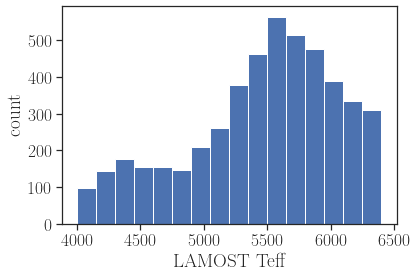

In [7]:
plt.xlabel("LAMOST Teff")
plt.ylabel("count")
plt.hist(d.teff, bins=tbins);

In [8]:
rnlabel = "variability amplitude $R_\mathrm{per}$\n normalized by Kepler photometric precision"
rlabel = "variability amplitude $R_\mathrm{per}$ (ppm)"
pnlabel = r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$"
dtlabel = 'empirical detection threshold'
tefflabel = 'LAMOST $T_\mathrm{eff}$ (K)'
protlabel = 'rotation period $P_\mathrm{rot}$ (days)'

## Fitting Rper vs Prot

In [14]:
resdir = 'plfit_results_t%d_pct/'%dt

In [18]:
resume = True

plfit_results_t150_pct/teff4000-4150
10.3922 43.075799999999994

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break   8030.60   1994.34   7966.59   4783.45  10964.34    531.88      1.00
    lnp_break      2.66      0.28      2.57      2.34      3.15    402.57      1.00
  lnxmodel[0]      3.75      0.02      3.75      3.72      3.76    125.32      1.00
  lnxmodel[1]      3.73      0.02      3.74      3.71      3.76    293.64      1.00
  lnxmodel[2]      2.53      0.03      2.53      2.49      2.57  11882.39      1.00
  lnxmodel[3]      3.63      0.02      3.63      3.59      3.67  10182.55      1.00
  lnxmodel[4]      2.96      0.03      2.96      2.92      3.00   9875.65      1.00
  lnxmodel[5]      2.64      0.03      2.64      2.61      2.68  13301.00      1.00
  lnxmodel[6]      2.59      0.03      2.58      2.55      2.63    946.97      1.00
  lnxmodel[7]      3.48      0.03      3.48      3.45      3.52  17265.29      1.00
  lnxmodel[

plfit_results_t150_pct/teff4300-4450
10.594 42.69

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break   8519.02   1349.87   8390.92   6530.50  10475.04    122.76      1.00
    lnp_break      3.14      0.15      3.15      3.00      3.34     79.63      1.00
  lnxmodel[0]      3.20      0.01      3.20      3.19      3.22  21131.01      1.00
  lnxmodel[1]      2.84      0.01      2.84      2.83      2.86  19312.53      1.00
  lnxmodel[2]      3.41      0.01      3.41      3.40      3.43   9064.98      1.00
  lnxmodel[3]      3.71      0.01      3.71      3.70      3.73   6686.57      1.00
  lnxmodel[4]      3.28      0.01      3.28      3.27      3.30  16138.03      1.00
  lnxmodel[5]      2.89      0.01      2.89      2.88      2.91  15436.38      1.00
  lnxmodel[6]      3.21      0.01      3.21      3.20      3.23  14971.84      1.00
  lnxmodel[7]      2.60      0.01      2.60      2.58      2.61  15475.40      1.00
  lnxmodel[8]      3.18  

plfit_results_t150_pct/teff4450-4600
9.7415 39.4255

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break   9242.59   1416.89   9081.59   7071.48  11216.08    118.05      1.00
    lnp_break      3.01      0.14      3.04      2.86      3.20     84.79      1.01
  lnxmodel[0]      2.84      0.01      2.84      2.82      2.86  18447.81      1.00
  lnxmodel[1]      3.40      0.01      3.40      3.38      3.42  16291.92      1.00
  lnxmodel[2]      2.78      0.01      2.78      2.76      2.80  19095.96      1.00
  lnxmodel[3]      2.47      0.01      2.47      2.45      2.49  21223.84      1.00
  lnxmodel[4]      3.15      0.01      3.15      3.13      3.17  16518.88      1.00
  lnxmodel[5]      2.79      0.01      2.79      2.77      2.81  14606.22      1.00
  lnxmodel[6]      2.38      0.01      2.38      2.36      2.39   9855.55      1.00
  lnxmodel[7]      3.38      0.01      3.38      3.36      3.40  13665.78      1.00
  lnxmodel[8]      2.62

plfit_results_t150_pct/teff4600-4750
10.241249999999999 38.0495

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  11501.18   1507.61  11414.87   9172.26  14133.12    677.15      1.00
    lnp_break      2.97      0.08      2.97      2.84      3.10    602.35      1.00
  lnxmodel[0]      3.45      0.01      3.45      3.44      3.46  18730.69      1.00
  lnxmodel[1]      2.65      0.01      2.65      2.64      2.66  18520.30      1.00
  lnxmodel[2]      3.27      0.01      3.27      3.26      3.28  15961.45      1.00
  lnxmodel[3]      2.53      0.01      2.53      2.52      2.54  18993.21      1.00
  lnxmodel[4]      3.16      0.01      3.16      3.14      3.17  13652.72      1.00
  lnxmodel[5]      3.15      0.01      3.15      3.14      3.16  15141.98      1.00
  lnxmodel[6]      2.43      0.01      2.43      2.42      2.44  19752.49      1.00
  lnxmodel[7]      3.13      0.01      3.13      3.12      3.14  13584.45      1.00
  lnxmodel[

plfit_results_t150_pct/teff4750-4900
8.2715 36.906

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  11893.17   1330.29  11852.23   9801.51  14091.59   2136.60      1.00
    lnp_break      2.98      0.05      2.98      2.90      3.07   2327.58      1.00
  lnxmodel[0]      3.39      0.02      3.39      3.36      3.42   7679.68      1.00
  lnxmodel[1]      2.77      0.02      2.77      2.74      2.79  16982.32      1.00
  lnxmodel[2]      2.86      0.02      2.86      2.83      2.88  15880.33      1.00
  lnxmodel[3]      3.13      0.02      3.13      3.10      3.16  15935.15      1.00
  lnxmodel[4]      3.56      0.02      3.56      3.53      3.58   4452.68      1.00
  lnxmodel[5]      3.15      0.02      3.15      3.12      3.18  11891.99      1.00
  lnxmodel[6]      2.75      0.02      2.75      2.73      2.78  15980.63      1.00
  lnxmodel[7]      2.85      0.02      2.85      2.82      2.87  20793.44      1.00
  lnxmodel[8]      3.13 

plfit_results_t150_pct/teff4900-5050
8.21695 34.30365

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  11351.68   1150.80  11348.87   9568.35  13320.29    667.08      1.00
    lnp_break      2.94      0.06      2.94      2.84      3.05    791.77      1.00
  lnxmodel[0]      2.43      0.01      2.43      2.41      2.45  16126.53      1.00
  lnxmodel[1]      3.42      0.01      3.42      3.40      3.44  13690.81      1.00
  lnxmodel[2]      3.47      0.01      3.47      3.45      3.49  10443.08      1.00
  lnxmodel[3]      2.58      0.02      2.58      2.56      2.60  17228.66      1.00
  lnxmodel[4]      2.71      0.01      2.71      2.68      2.72  19945.67      1.00
  lnxmodel[5]      3.40      0.01      3.40      3.38      3.42  13674.74      1.00
  lnxmodel[6]      3.21      0.01      3.20      3.18      3.23   9664.89      1.00
  lnxmodel[7]      3.38      0.01      3.38      3.36      3.40  18066.17      1.00
  lnxmodel[8]      2.

plfit_results_t150_pct/teff5050-5200
7.65085 35.06465

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  12920.39   1153.19  12873.09  11062.06  14831.00   1091.08      1.00
    lnp_break      2.91      0.05      2.91      2.83      2.98   1247.03      1.00
  lnxmodel[0]      2.89      0.01      2.89      2.88      2.91  15481.62      1.00
  lnxmodel[1]      3.34      0.01      3.34      3.32      3.35  17850.63      1.00
  lnxmodel[2]      2.18      0.01      2.18      2.16      2.20  17415.00      1.00
  lnxmodel[3]      2.08      0.01      2.08      2.06      2.09   7035.61      1.00
  lnxmodel[4]      3.37      0.01      3.37      3.36      3.39  16660.75      1.00
  lnxmodel[5]      2.45      0.01      2.45      2.44      2.47  19379.79      1.00
  lnxmodel[6]      3.52      0.01      3.52      3.51      3.54   2157.50      1.00
  lnxmodel[7]      3.20      0.01      3.20      3.18      3.22  15376.31      1.00
  lnxmodel[8]      3.

plfit_results_t150_pct/teff5200-5350
7.0075 32.5819

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  13347.90   1011.91  13349.54  11574.30  14950.90    304.47      1.00
    lnp_break      2.80      0.04      2.80      2.74      2.87    346.59      1.00
  lnxmodel[0]      3.26      0.00      3.26      3.26      3.26  15039.64      1.00
  lnxmodel[1]      3.42      0.00      3.42      3.41      3.42  18126.79      1.00
  lnxmodel[2]      3.00      0.00      3.00      3.00      3.01  16098.62      1.00
  lnxmodel[3]      2.01      0.00      2.01      2.01      2.02  14627.69      1.00
  lnxmodel[4]      2.04      0.00      2.04      2.03      2.04  14447.99      1.00
  lnxmodel[5]      3.01      0.00      3.01      3.01      3.02  23147.35      1.00
  lnxmodel[6]      3.28      0.00      3.28      3.28      3.29  15931.35      1.00
  lnxmodel[7]      2.97      0.00      2.97      2.97      2.97  13583.30      1.00
  lnxmodel[8]      2.77

plfit_results_t150_pct/teff5350-5500
5.9175 29.5266

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  12810.53   1002.64  12806.09  11238.18  14529.01   1621.41      1.00
    lnp_break      2.74      0.04      2.74      2.68      2.80   1792.45      1.00
  lnxmodel[0]      3.13      0.01      3.13      3.12      3.14  22238.48      1.00
  lnxmodel[1]      3.18      0.01      3.18      3.17      3.19  18967.85      1.00
  lnxmodel[2]      2.92      0.01      2.92      2.91      2.93  13543.09      1.00
  lnxmodel[3]      3.15      0.01      3.15      3.14      3.16  20734.43      1.00
  lnxmodel[4]      2.83      0.01      2.83      2.82      2.84  14703.42      1.00
  lnxmodel[5]      3.00      0.01      3.00      2.99      3.01  13043.80      1.00
  lnxmodel[6]      2.82      0.01      2.82      2.81      2.83  18415.06      1.00
  lnxmodel[7]      2.90      0.01      2.90      2.89      2.91  19086.45      1.00
  lnxmodel[8]      2.24

plfit_results_t150_pct/teff5500-5650
5.8566 26.188999999999997

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  14505.81    977.66  14450.07  12988.28  16126.90    261.04      1.00
    lnp_break      2.57      0.03      2.57      2.51      2.62    344.89      1.00
  lnxmodel[0]      3.10      0.00      3.10      3.09      3.10  19757.73      1.00
  lnxmodel[1]      3.24      0.00      3.24      3.24      3.25   5343.73      1.00
  lnxmodel[2]      2.92      0.00      2.92      2.91      2.92  16262.98      1.00
  lnxmodel[3]      1.98      0.00      1.98      1.97      1.98  21095.66      1.00
  lnxmodel[4]      2.82      0.00      2.82      2.81      2.83  18046.71      1.00
  lnxmodel[5]      2.79      0.00      2.79      2.79      2.80  18986.91      1.00
  lnxmodel[6]      2.68      0.00      2.68      2.67      2.68   6571.23      1.00
  lnxmodel[7]      2.44      0.00      2.44      2.44      2.45  18643.21      1.00
  lnxmodel[8

plfit_results_t150_pct/teff5650-5800
4.3340000000000005 22.68275

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  10416.13    875.70  10376.71   8984.64  11801.53   2104.29      1.00
    lnp_break      2.52      0.04      2.52      2.45      2.58   2012.75      1.00
  lnxmodel[0]      1.99      0.01      1.99      1.97      2.00  20670.72      1.00
  lnxmodel[1]      2.52      0.01      2.52      2.51      2.54  17349.76      1.00
  lnxmodel[2]      2.77      0.01      2.77      2.75      2.78  21146.60      1.00
  lnxmodel[3]      2.96      0.01      2.96      2.95      2.98  17294.68      1.00
  lnxmodel[4]      3.09      0.01      3.09      3.08      3.11   1646.78      1.00
  lnxmodel[5]      2.10      0.01      2.10      2.09      2.12  20038.03      1.00
  lnxmodel[6]      2.44      0.01      2.44      2.43      2.46  17618.74      1.00
  lnxmodel[7]      2.66      0.01      2.66      2.64      2.67  19102.19      1.00
  lnxmodel

plfit_results_t150_pct/teff5800-5950
3.354 19.6812

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  12393.87    875.04  12374.81  10999.09  13804.24    840.03      1.00
    lnp_break      2.23      0.03      2.23      2.18      2.28    246.75      1.00
  lnxmodel[0]      2.71      0.01      2.71      2.70      2.71  15510.02      1.00
  lnxmodel[1]      2.51      0.01      2.51      2.50      2.52  20237.14      1.00
  lnxmodel[2]      2.62      0.01      2.62      2.61      2.63  16557.76      1.00
  lnxmodel[3]      1.97      0.01      1.97      1.96      1.98  17385.92      1.00
  lnxmodel[4]      1.89      0.01      1.89      1.88      1.89  14378.31      1.00
  lnxmodel[5]      2.79      0.01      2.79      2.78      2.80  15846.78      1.00
  lnxmodel[6]      2.11      0.01      2.11      2.10      2.11  17175.42      1.00
  lnxmodel[7]      2.43      0.01      2.43      2.42      2.44  20847.96      1.00
  lnxmodel[8]      2.79 

plfit_results_t150_pct/teff5950-6100
2.5210500000000002 20.06225

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break   9804.99   1227.02   9763.14   7758.90  11808.72    116.76      1.01
    lnp_break      1.93      0.06      1.92      1.83      2.02    220.40      1.00
  lnxmodel[0]      2.42      0.02      2.42      2.39      2.45    169.74      1.01
  lnxmodel[1]      2.70      0.02      2.70      2.67      2.73  17463.15      1.00
  lnxmodel[2]      2.40      0.02      2.40      2.37      2.43  13380.80      1.00
  lnxmodel[3]      2.28      0.02      2.28      2.25      2.31   3825.64      1.00
  lnxmodel[4]      2.16      0.02      2.16      2.13      2.19    457.15      1.01
  lnxmodel[5]      2.29      0.02      2.29      2.26      2.32   3231.67      1.00
  lnxmodel[6]      2.71      0.02      2.71      2.68      2.74  13522.53      1.00
  lnxmodel[7]      1.86      0.02      1.86      1.83      1.89  18806.89      1.00
  lnxmodel

plfit_results_t150_pct/teff6100-6250
1.87675 16.266

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break   9363.19   1176.68   9277.35   7413.42  11213.01     69.55      1.01
    lnp_break      1.37      0.09      1.37      1.23      1.52     58.81      1.00
  lnxmodel[0]      1.71      0.10      1.72      1.57      1.89   4536.69      1.00
  lnxmodel[1]      2.17      0.10      2.19      1.99      2.31     42.88      1.01
  lnxmodel[2]      2.14      0.14      2.08      2.00      2.41     15.29      1.02
  lnxmodel[3]      1.38      0.11      1.39      1.20      1.59   5769.52      1.00
  lnxmodel[4]      1.88      0.12      1.84      1.75      2.11     22.87      1.02
  lnxmodel[5]      2.12      0.10      2.15      1.93      2.25     36.94      1.01
  lnxmodel[6]      2.00      0.11      2.04      1.79      2.14     23.06      1.02
  lnxmodel[7]      2.17      0.10      2.15      2.03      2.34     65.35      1.01
  lnxmodel[8]      1.47

plfit_results_t150_pct/teff6250-6400
1.4138 18.688999999999997

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break    983.69    118.67    978.14    789.32   1168.42    169.85      1.01
    lnp_break      2.08      0.08      2.08      1.95      2.21    143.49      1.00
  lnxmodel[0]      0.84      0.02      0.84      0.80      0.87  12066.70      1.00
  lnxmodel[1]      1.20      0.03      1.20      1.16      1.23   8915.36      1.00
  lnxmodel[2]      1.62      0.03      1.62      1.59      1.66  14118.04      1.00
  lnxmodel[3]      1.67      0.03      1.67      1.63      1.70  15474.96      1.00
  lnxmodel[4]      1.91      0.03      1.91      1.87      1.95  13388.89      1.00
  lnxmodel[5]      1.18      0.03      1.18      1.14      1.22   6669.45      1.00
  lnxmodel[6]      1.64      0.03      1.64      1.60      1.68  11709.43      1.00
  lnxmodel[7]      2.37      0.03      2.37      2.34      2.41  16816.38      1.00
  lnxmodel[8

IndexError: index 17 is out of bounds for axis 0 with size 17

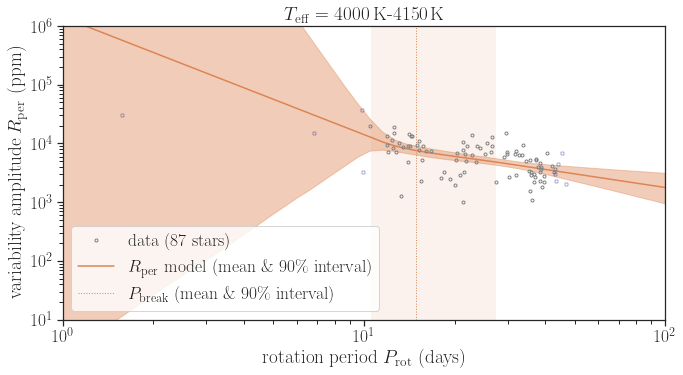

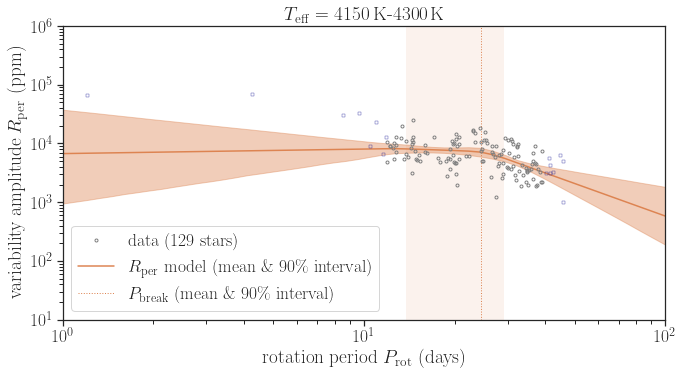

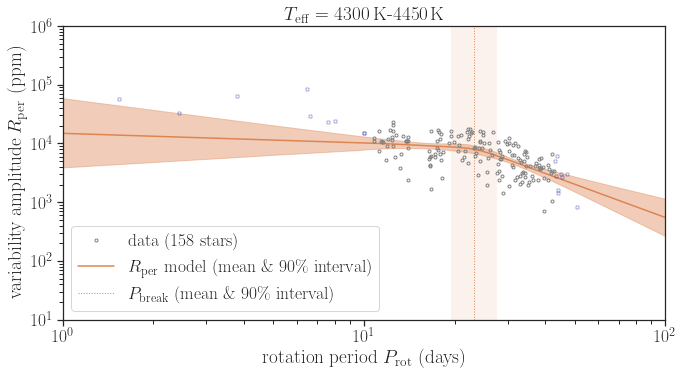

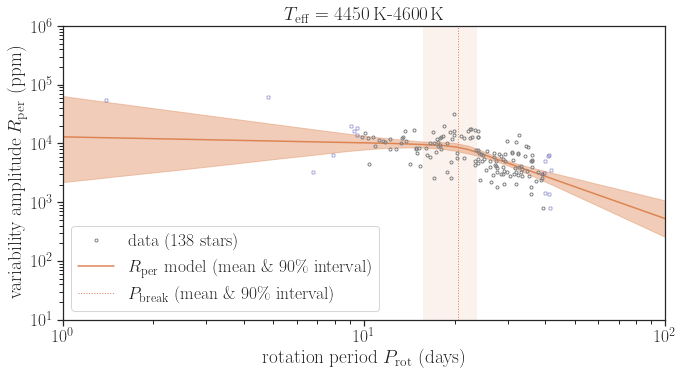

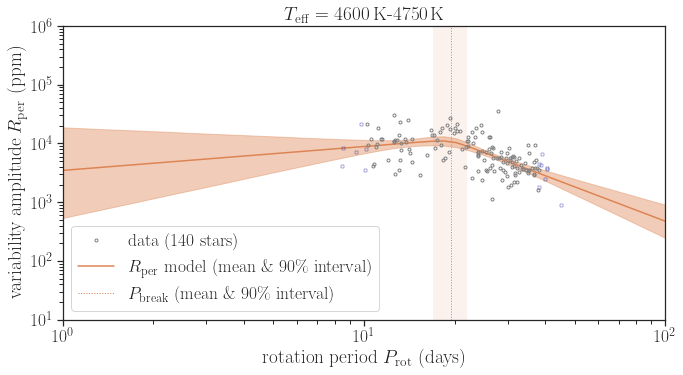

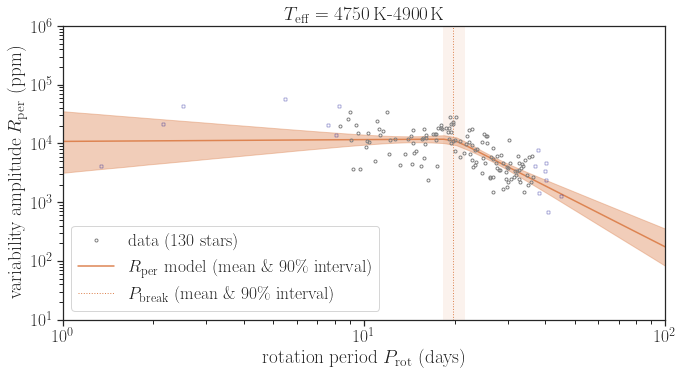

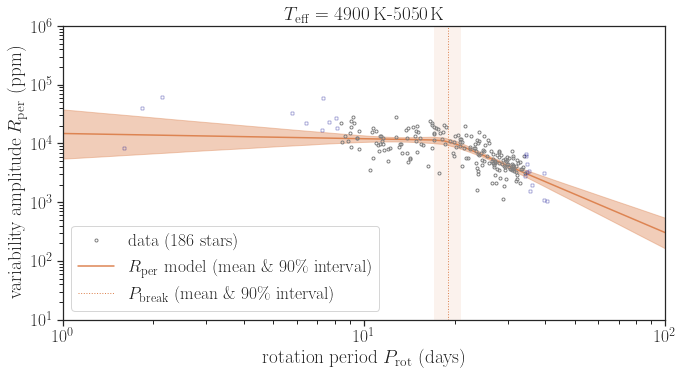

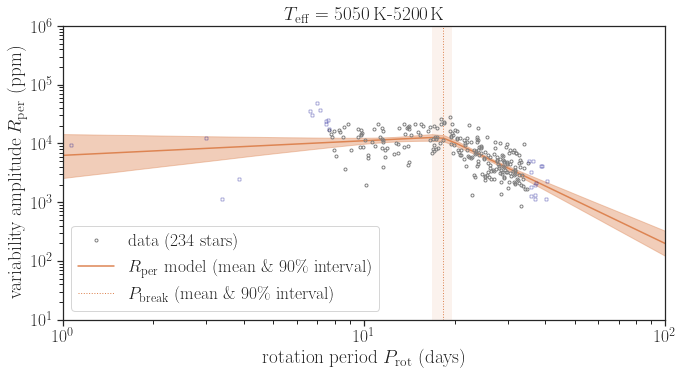

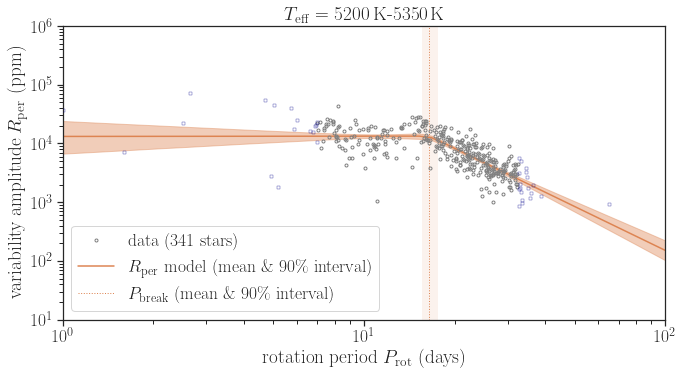

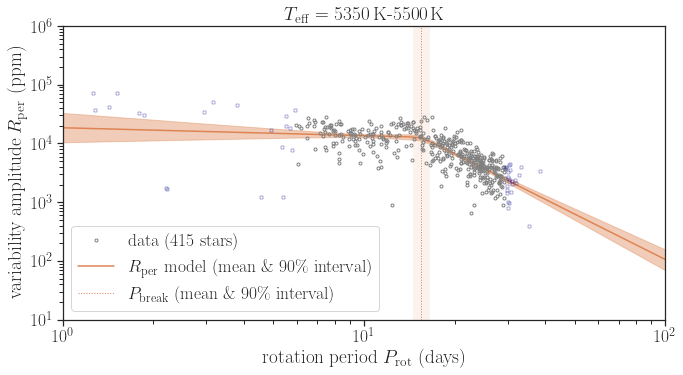

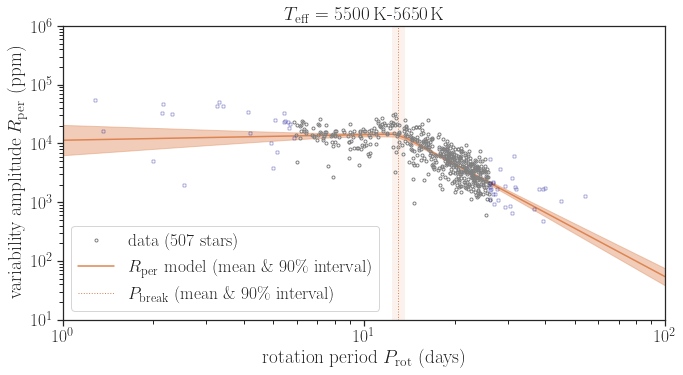

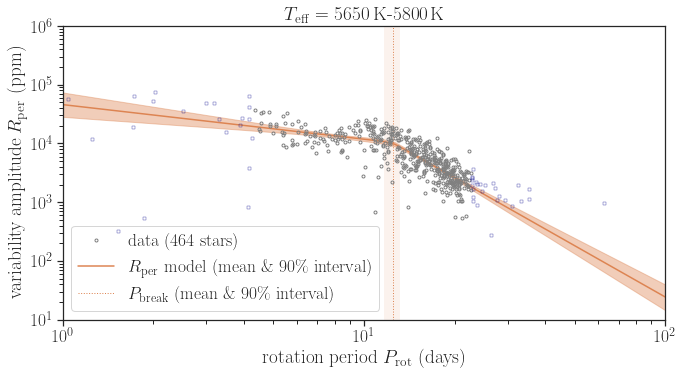

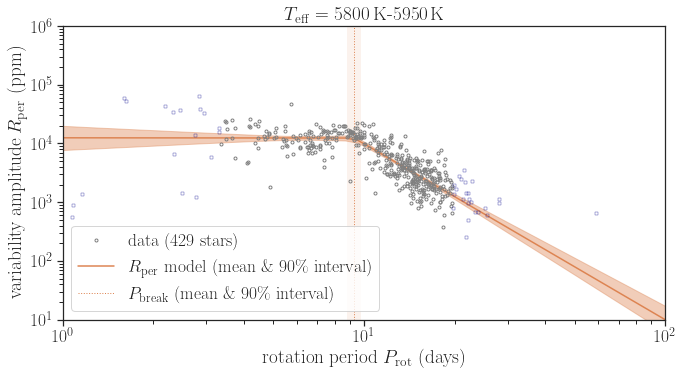

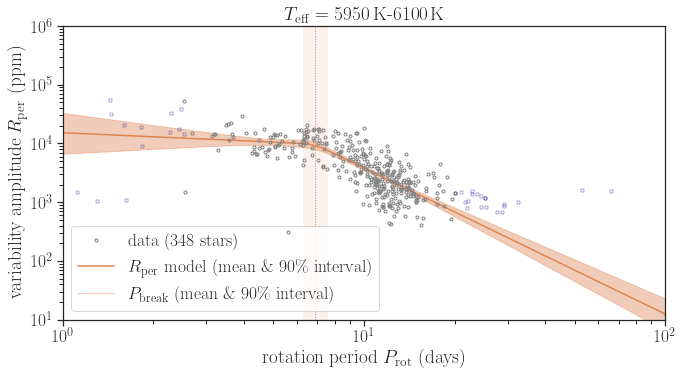

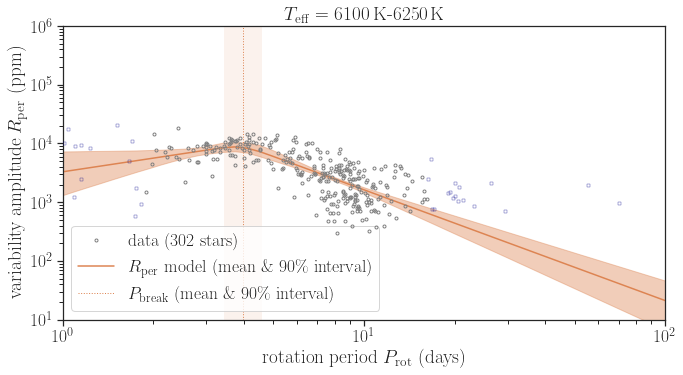

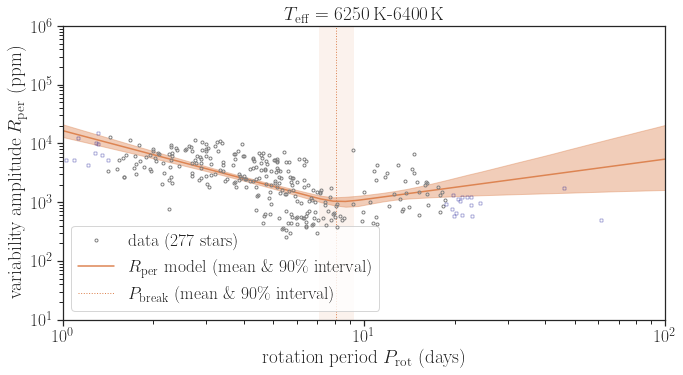

In [30]:
for i in range(len(tbins)):
    tl, tu = tbins[i], tbins[i+1]
    outname = resdir+"teff%d-%d"%(tl, tu)
    print (outname)    

    idx = (d.teff>tl) & (d.teff<tu) #& (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Prot, [5, 95])
    print (pmin, pmax)
    #pmin, pmax = 1., 100.
    
    idxp = (pmin<d.Prot) & (d.Prot<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Prot), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Prot, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))  
        mcmc.print_summary()
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 5000//5, 10000//5
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax, xb_lower=np.fmax(pmin, 3.), xb_upper=np.fmin(pmax, 30.))
        mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.exp(jnp.mean(samples['logrmodeldense'], axis=0))
    r5, r95 = jnp.exp(jnp.percentile(samples['logrmodeldense'], q=jnp.array([5, 95]), axis=0))
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12*0.9,6*0.9))
    plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(1, 100)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(protlabel)
    plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=1, zorder=1000, label='data (%d stars)'%len(pobs))
    #plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=1, zorder=1000, alpha=0.4)
    plt.plot(pobs_out, robs_out, 's', color='darkblue', zorder=1000, alpha=0.8, markersize=3, mfc='none', mew=0.4)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$P_\mathrm{break}$ (mean \& 90\% interval)')
                #label='$P_\mathrm{break}=%.1f\pm%.1f\,\mathrm{days}$'%(pb, pbsd), )
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1)
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_model.png", dpi=200, bbox_inches="tight")

    #keys = ["R_break", "p_break", "power_long", "power_short", "logrsigma"]
    #labels = ['Rb', 'Pb', 'pl', 'ps', 'logrsigma']
    #hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
    #fig = corner.corner(hyper, labels=labels, show_titles="%.2f")
    #plt.savefig(outname+"_corner.png", dpi=200, bbox_inches="tight")

## Fitting Rper vs Ro

In [122]:
resdir = 'plfitro_results_t%d_pct/'%dt

In [36]:
resdir
resume = True

plfitro_results_t150_pct/teff4000-4150
0.26808087705115285 1.1123180126932566

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break   4566.48   1084.23   4369.49   2952.14   6233.02    261.28      1.00
    lnp_break     -0.17      0.21     -0.14     -0.50      0.11    332.02      1.00
  lnxmodel[0]      0.08      0.03      0.09      0.05      0.11    127.71      1.01
  lnxmodel[1]     -1.11      0.04     -1.11     -1.18     -1.05   4672.62      1.00
  lnxmodel[2]     -0.04      0.03     -0.04     -0.10      0.02   4583.64      1.00
  lnxmodel[3]     -0.71      0.04     -0.71     -0.77     -0.65   5036.88      1.00
  lnxmodel[4]     -1.03      0.04     -1.03     -1.09     -0.97   7319.60      1.00
  lnxmodel[5]     -1.06      0.04     -1.06     -1.11     -0.99   3230.90      1.00
  lnxmodel[6]     -0.17      0.04     -0.17     -0.22     -0.11   6789.71      1.00
  lnxmodel[7]     -0.26      0.04     -0.26     -0.32     -0.20   6776.44      1.

plfitro_results_t150_pct/teff4300-4450
0.3117433408156488 1.276602040310339

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break   7846.71   1318.38   7964.73   5560.45   9934.43     83.16      1.00
    lnp_break     -0.29      0.14     -0.31     -0.52     -0.08     73.63      1.00
  lnxmodel[0]     -0.30      0.01     -0.30     -0.31     -0.29   8748.96      1.00
  lnxmodel[1]     -0.63      0.01     -0.63     -0.64     -0.62   5919.36      1.00
  lnxmodel[2]     -0.08      0.01     -0.08     -0.10     -0.07   7705.75      1.00
  lnxmodel[3]      0.17      0.01      0.17      0.16      0.19   3012.93      1.00
  lnxmodel[4]     -0.19      0.01     -0.19     -0.20     -0.18   7628.49      1.00
  lnxmodel[5]     -0.63      0.01     -0.63     -0.64     -0.62   8395.41      1.00
  lnxmodel[6]     -0.32      0.01     -0.32     -0.33     -0.31   7125.36      1.00
  lnxmodel[7]     -0.90      0.01     -0.90     -0.92     -0.89   7027.12      1.00

plfitro_results_t150_pct/teff4450-4600
0.30953619053220893 1.2842556051553946

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break   9093.02   1275.86   9164.33   7513.08  11134.78    185.30      1.00
    lnp_break     -0.36      0.10     -0.37     -0.51     -0.26    158.80      1.00
  lnxmodel[0]     -0.59      0.02     -0.59     -0.61     -0.56   6601.46      1.00
  lnxmodel[1]      0.00      0.02      0.00     -0.02      0.03   6839.43      1.00
  lnxmodel[2]     -0.66      0.02     -0.66     -0.68     -0.64   8614.99      1.00
  lnxmodel[3]     -0.93      0.02     -0.93     -0.95     -0.90   6272.42      1.00
  lnxmodel[4]     -0.26      0.02     -0.26     -0.28     -0.23   5576.60      1.00
  lnxmodel[5]     -0.66      0.02     -0.66     -0.68     -0.63   4874.00      1.00
  lnxmodel[6]     -1.07      0.02     -1.07     -1.09     -1.05   2345.61      1.00
  lnxmodel[7]     -0.06      0.02     -0.06     -0.09     -0.04   7791.00      1.

plfitro_results_t150_pct/teff4600-4750
0.3663947501205649 1.347351382507454

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  11649.96   1642.01  11636.00   8886.77  14310.55    202.63      1.01
    lnp_break     -0.40      0.09     -0.39     -0.55     -0.28    395.91      1.00
  lnxmodel[0]      0.06      0.01      0.06      0.05      0.07   8860.25      1.00
  lnxmodel[1]     -0.67      0.01     -0.67     -0.68     -0.66   7731.48      1.00
  lnxmodel[2]     -0.05      0.01     -0.05     -0.06     -0.04  16900.44      1.00
  lnxmodel[3]     -0.80      0.01     -0.80     -0.81     -0.79   6185.77      1.00
  lnxmodel[4]     -0.20      0.01     -0.19     -0.20     -0.19   7049.59      1.00
  lnxmodel[5]     -0.19      0.01     -0.19     -0.19     -0.18   8092.73      1.00
  lnxmodel[6]     -0.95      0.01     -0.95     -0.96     -0.94   4945.76      1.00
  lnxmodel[7]     -0.24      0.01     -0.24     -0.25     -0.23   7931.79      1.00

plfitro_results_t150_pct/teff4750-4900
0.31843588885519125 1.4015011569725953

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  11409.68   1302.09  11371.49   9191.78  13524.35    272.91      1.00
    lnp_break     -0.28      0.06     -0.28     -0.37     -0.19    348.66      1.00
  lnxmodel[0]      0.11      0.01      0.11      0.09      0.13   7141.55      1.00
  lnxmodel[1]     -0.54      0.02     -0.54     -0.56     -0.52   8750.10      1.00
  lnxmodel[2]      0.32      0.01      0.33      0.31      0.34     59.20      1.01
  lnxmodel[3]     -0.40      0.01     -0.40     -0.42     -0.38  10566.04      1.00
  lnxmodel[4]     -0.11      0.02     -0.11     -0.13     -0.09   9982.54      1.00
  lnxmodel[5]      0.27      0.01      0.27      0.25      0.29   4610.25      1.00
  lnxmodel[6]     -0.11      0.01     -0.11     -0.13     -0.09   7691.94      1.00
  lnxmodel[7]     -0.50      0.01     -0.50     -0.52     -0.48   9905.15      1.

plfitro_results_t150_pct/teff4900-5050
0.3440990699725235 1.4254791572317067

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  11342.79   1184.17  11345.58   9271.18  13127.78   1790.30      1.00
    lnp_break     -0.24      0.07     -0.25     -0.35     -0.14   1666.19      1.00
  lnxmodel[0]     -0.73      0.01     -0.73     -0.75     -0.70   9070.42      1.00
  lnxmodel[1]      0.25      0.02      0.25      0.23      0.28   7560.82      1.00
  lnxmodel[2]      0.29      0.01      0.29      0.26      0.31   3306.60      1.00
  lnxmodel[3]     -0.62      0.01     -0.62     -0.64     -0.59   8572.14      1.00
  lnxmodel[4]     -0.49      0.02     -0.49     -0.52     -0.47   8444.20      1.00
  lnxmodel[5]      0.25      0.02      0.25      0.22      0.27   4930.11      1.00
  lnxmodel[6]      0.03      0.02      0.03      0.01      0.06   6624.92      1.00
  lnxmodel[7]      0.23      0.02      0.23      0.20      0.25   5934.99      1.0

plfitro_results_t150_pct/teff5050-5200
0.35219582856490217 1.5759973944215393

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  13049.42   1171.32  13044.51  11082.87  14845.28    522.15      1.00
    lnp_break     -0.20      0.05     -0.20     -0.27     -0.12    347.33      1.00
  lnxmodel[0]     -0.25      0.01     -0.25     -0.26     -0.24   9000.36      1.00
  lnxmodel[1]      0.23      0.01      0.23      0.22      0.24  10232.17      1.00
  lnxmodel[2]     -0.89      0.01     -0.89     -0.90     -0.88   8218.82      1.00
  lnxmodel[3]     -1.04      0.01     -1.04     -1.04     -1.03     28.89      1.00
  lnxmodel[4]      0.30      0.01      0.30      0.29      0.31  10955.31      1.00
  lnxmodel[5]     -0.60      0.01     -0.60     -0.61     -0.59   9989.82      1.00
  lnxmodel[6]      0.44      0.01      0.44      0.43      0.45    267.18      1.00
  lnxmodel[7]      0.07      0.01      0.07      0.06      0.08   8995.96      1.

plfitro_results_t150_pct/teff5200-5350
0.3536202777007134 1.5989605780721439

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  13477.05   1085.61  13458.96  11748.98  15243.54    981.43      1.00
    lnp_break     -0.18      0.04     -0.18     -0.24     -0.12   1548.42      1.00
  lnxmodel[0]      0.25      0.00      0.25      0.25      0.26   7960.40      1.00
  lnxmodel[1]      0.43      0.00      0.43      0.42      0.43   7416.27      1.00
  lnxmodel[2]      0.00      0.00      0.00     -0.00      0.01   6922.18      1.00
  lnxmodel[3]     -0.98      0.00     -0.98     -0.98     -0.98  11124.96      1.00
  lnxmodel[4]     -0.96      0.00     -0.96     -0.97     -0.96   6005.54      1.00
  lnxmodel[5]      0.03      0.00      0.03      0.02      0.03   8444.16      1.00
  lnxmodel[6]      0.24      0.00      0.24      0.24      0.25   8727.82      1.00
  lnxmodel[7]     -0.02      0.00     -0.02     -0.03     -0.02  10415.61      1.0

plfitro_results_t150_pct/teff5350-5500
0.32597653910297825 1.616856564811474

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  12923.33   1000.94  12949.41  11392.43  14530.12    191.84      1.00
    lnp_break     -0.16      0.04     -0.16     -0.23     -0.09     91.60      1.00
  lnxmodel[0]      0.27      0.01      0.27      0.26      0.28   6682.94      1.00
  lnxmodel[1]      0.33      0.01      0.33      0.32      0.34   6094.97      1.00
  lnxmodel[2]      0.05      0.01      0.05      0.04      0.06   5061.39      1.00
  lnxmodel[3]      0.29      0.01      0.29      0.29      0.30   7209.38      1.00
  lnxmodel[4]     -0.04      0.00     -0.04     -0.05     -0.03   6671.93      1.00
  lnxmodel[5]      0.16      0.01      0.16      0.15      0.16   7855.27      1.00
  lnxmodel[6]     -0.10      0.00     -0.10     -0.11     -0.10   6315.94      1.00
  lnxmodel[7]     -0.02      0.00     -0.02     -0.02     -0.01   6272.76      1.0

plfitro_results_t150_pct/teff5500-5650
0.3766486594612409 1.6603364704225267

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  14728.07   1012.66  14708.39  13029.41  16325.20    748.65      1.00
    lnp_break     -0.18      0.03     -0.18     -0.23     -0.13    712.90      1.00
  lnxmodel[0]      0.31      0.00      0.31      0.31      0.32   7085.89      1.00
  lnxmodel[1]     -0.95      0.00     -0.95     -0.96     -0.95   7420.40      1.00
  lnxmodel[2]      0.48      0.00      0.48      0.47      0.48   9477.84      1.00
  lnxmodel[3]      0.14      0.00      0.14      0.13      0.14   8950.15      1.00
  lnxmodel[4]     -0.84      0.00     -0.84     -0.84     -0.83   7366.98      1.00
  lnxmodel[5]      0.08      0.00      0.08      0.08      0.09   8651.80      1.00
  lnxmodel[6]      0.05      0.00      0.05      0.04      0.06   7632.01      1.00
  lnxmodel[7]     -0.04      0.00     -0.04     -0.04     -0.03   7211.95      1.0

plfitro_results_t150_pct/teff5650-5800
0.3265526697025747 1.633128319718753

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  11713.87    814.68  11678.22  10367.07  13058.08    386.74      1.00
    lnp_break     -0.11      0.03     -0.11     -0.17     -0.07    426.64      1.00
  lnxmodel[0]     -0.62      0.00     -0.62     -0.62     -0.61   9375.42      1.00
  lnxmodel[1]     -0.12      0.00     -0.12     -0.12     -0.12   9740.39      1.00
  lnxmodel[2]      0.20      0.00      0.20      0.20      0.20   8162.91      1.00
  lnxmodel[3]      0.34      0.00      0.34      0.34      0.35   5984.36      1.00
  lnxmodel[4]     -0.50      0.00     -0.50     -0.50     -0.49  11944.73      1.00
  lnxmodel[5]     -0.08      0.00     -0.08     -0.08     -0.08   8494.66      1.00
  lnxmodel[6]      0.04      0.00      0.04      0.04      0.04   6339.90      1.00
  lnxmodel[7]      0.41      0.00      0.41      0.40      0.41   7652.38      1.00

plfitro_results_t150_pct/teff5800-5950
0.3147067360194978 1.7197515090635223

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  12547.04    858.76  12547.48  11164.63  13979.37   1164.55      1.00
    lnp_break     -0.15      0.03     -0.15     -0.19     -0.10    944.74      1.00
  lnxmodel[0]      0.37      0.01      0.37      0.35      0.40  12333.63      1.00
  lnxmodel[1]      0.11      0.01      0.11      0.09      0.13   7729.45      1.00
  lnxmodel[2]      0.13      0.01      0.13      0.11      0.15   6001.20      1.00
  lnxmodel[3]     -0.42      0.01     -0.42     -0.44     -0.40   8847.52      1.00
  lnxmodel[4]     -0.56      0.01     -0.56     -0.58     -0.54   6702.78      1.00
  lnxmodel[5]      0.41      0.01      0.41      0.39      0.43   3835.26      1.00
  lnxmodel[6]     -0.37      0.01     -0.37     -0.40     -0.35   8660.45      1.00
  lnxmodel[7]      0.07      0.01      0.07      0.04      0.09   5041.75      1.0

plfitro_results_t150_pct/teff5950-6100
0.30733667823852984 2.4089323904146953

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break   9838.43   1108.29   9806.17   7939.09  11525.52    983.99      1.00
    lnp_break     -0.13      0.05     -0.13     -0.21     -0.05    608.10      1.01
  lnxmodel[0]      0.40      0.03      0.39      0.36      0.44     96.14      1.04
  lnxmodel[1]      0.47      0.02      0.46      0.43      0.50   6652.05      1.00
  lnxmodel[2]      0.33      0.02      0.33      0.29      0.36  10899.36      1.00
  lnxmodel[3]      0.10      0.02      0.11      0.07      0.14   5601.72      1.00
  lnxmodel[4]     -0.07      0.02     -0.07     -0.11     -0.04   1084.61      1.01
  lnxmodel[5]      0.02      0.02      0.02     -0.02      0.05   9273.48      1.00
  lnxmodel[6]      0.43      0.02      0.43      0.39      0.46   4688.56      1.01
  lnxmodel[7]     -0.30      0.02     -0.30     -0.34     -0.26   5052.01      1.

plfitro_results_t150_pct/teff6100-6250
0.33601758723731345 2.596413878837754

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  10857.97   1001.93  10832.28   9198.02  12455.09    408.77      1.00
    lnp_break     -0.37      0.06     -0.37     -0.45     -0.27    191.99      1.00
  lnxmodel[0]     -0.01      0.08     -0.01     -0.14      0.11   7045.65      1.00
  lnxmodel[1]      0.32      0.08      0.33      0.19      0.45    613.23      1.00
  lnxmodel[2]      0.42      0.09      0.39      0.28      0.56     72.49      1.01
  lnxmodel[3]     -0.56      0.08     -0.56     -0.71     -0.42   7011.31      1.00
  lnxmodel[4]      0.12      0.09      0.10     -0.01      0.27     88.65      1.01
  lnxmodel[5]      0.28      0.08      0.29      0.13      0.40    486.93      1.00
  lnxmodel[6]      0.08      0.08      0.09     -0.06      0.20    712.99      1.00
  lnxmodel[7]      0.29      0.08      0.28      0.17      0.44    120.85      1.0

plfitro_results_t150_pct/teff6250-6400
0.38143284165196706 5.219090578250649

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break   1075.69     87.27   1073.23    940.19   1223.33   1660.62      1.00
    lnp_break      0.66      0.03      0.67      0.62      0.69   2519.90      1.00
  lnxmodel[0]     -0.70      0.02     -0.70     -0.73     -0.67   7933.28      1.00
  lnxmodel[1]     -0.32      0.02     -0.32     -0.34     -0.29   9252.51      1.00
  lnxmodel[2]      0.28      0.02      0.28      0.25      0.31   8864.12      1.00
  lnxmodel[3]      0.19      0.02      0.19      0.16      0.21   7246.92      1.00
  lnxmodel[4]      0.46      0.02      0.46      0.43      0.48  10330.05      1.00
  lnxmodel[5]      0.19      0.02      0.19      0.16      0.21   4339.97      1.00
  lnxmodel[6]      0.26      0.02      0.26      0.23      0.28   9866.18      1.00
  lnxmodel[7]      1.08      0.02      1.08      1.05      1.11   8404.57      1.0

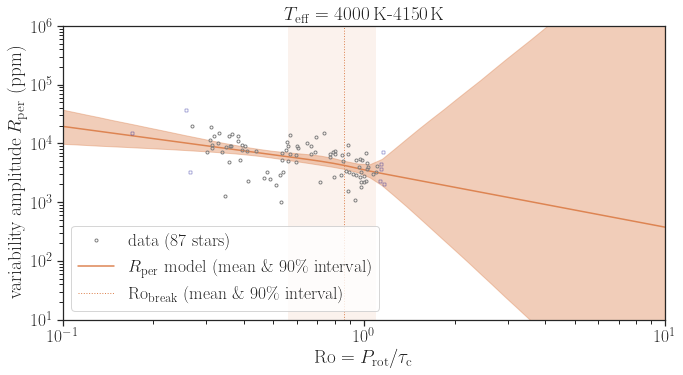

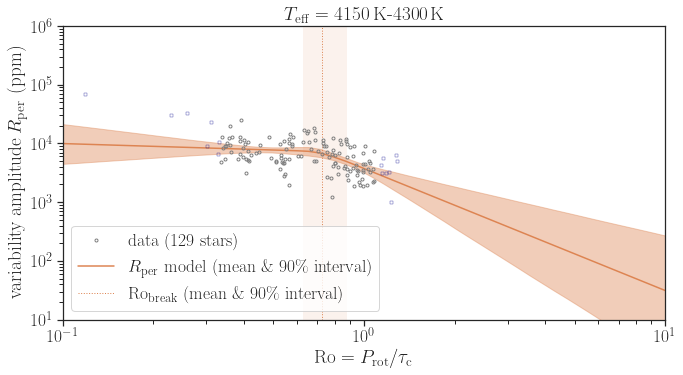

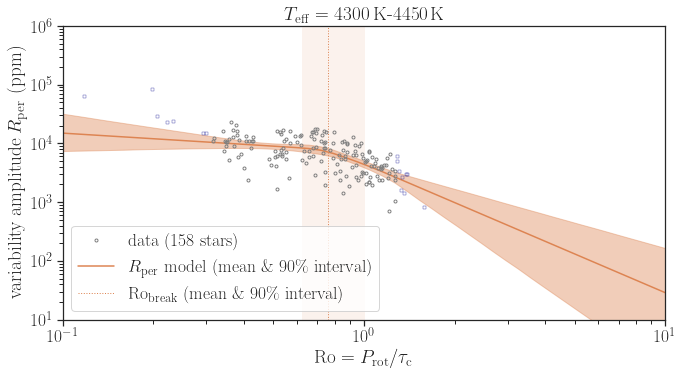

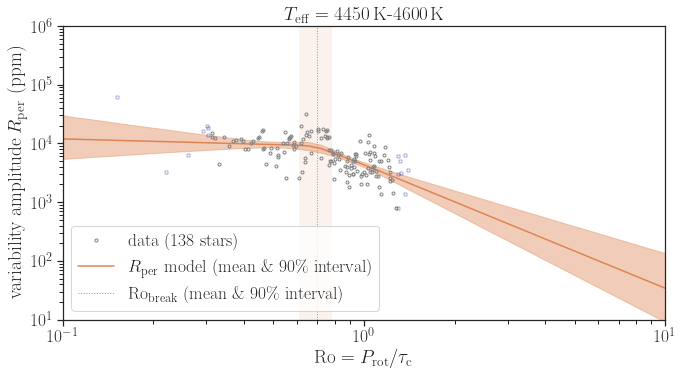

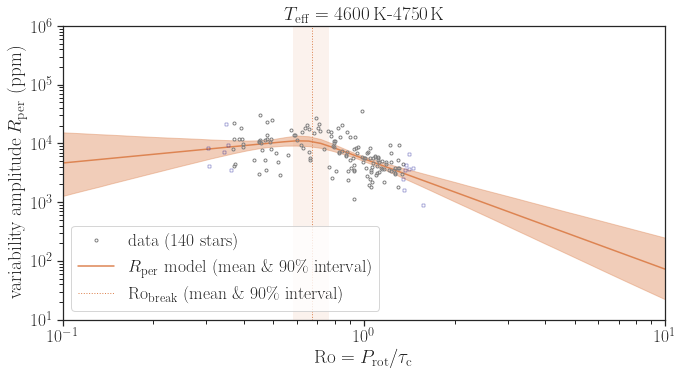

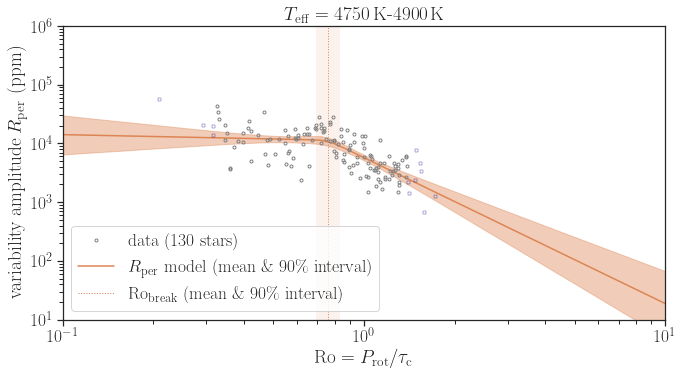

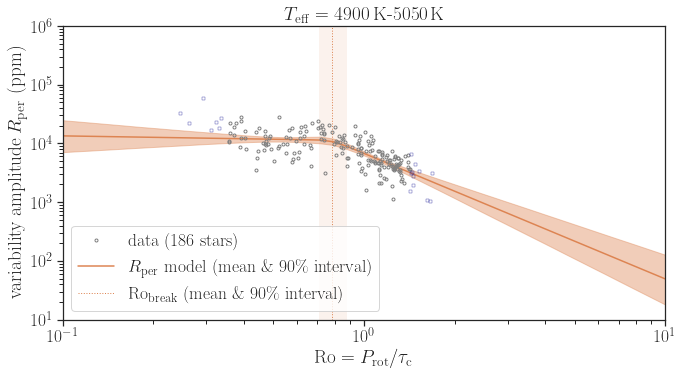

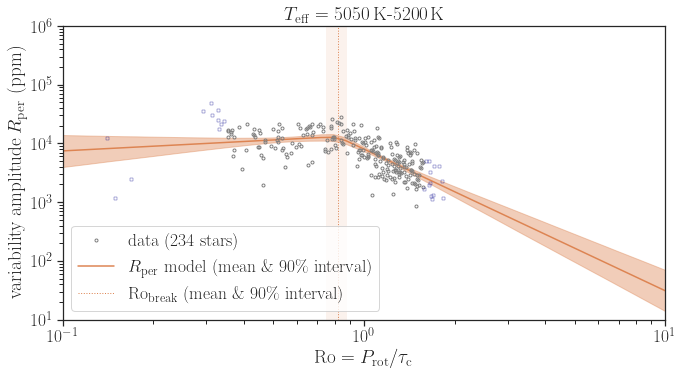

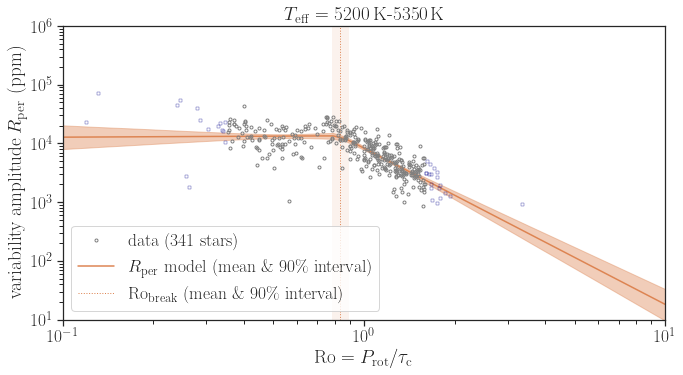

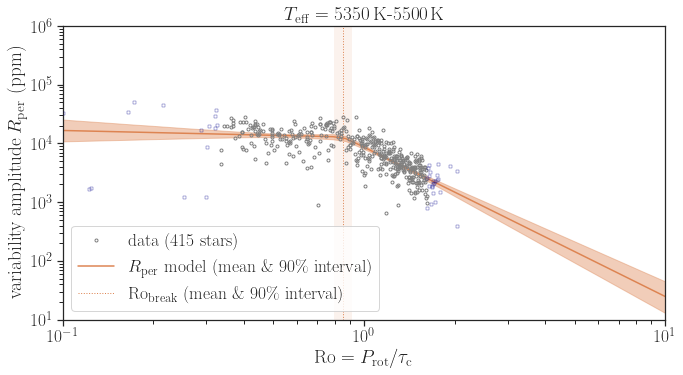

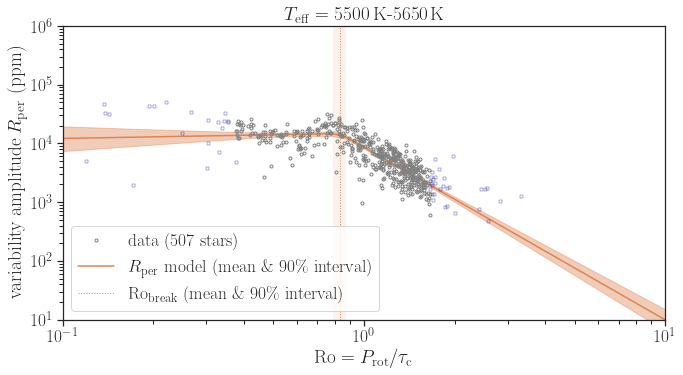

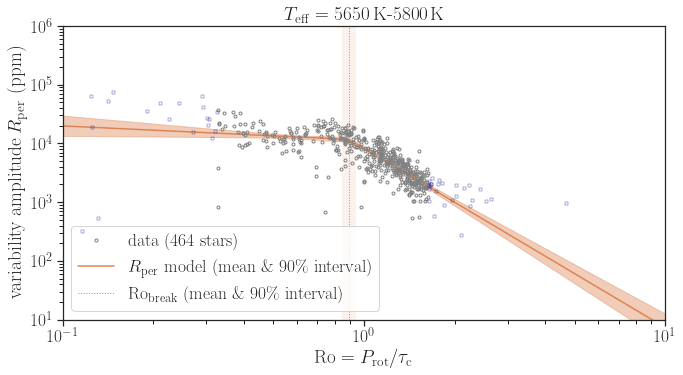

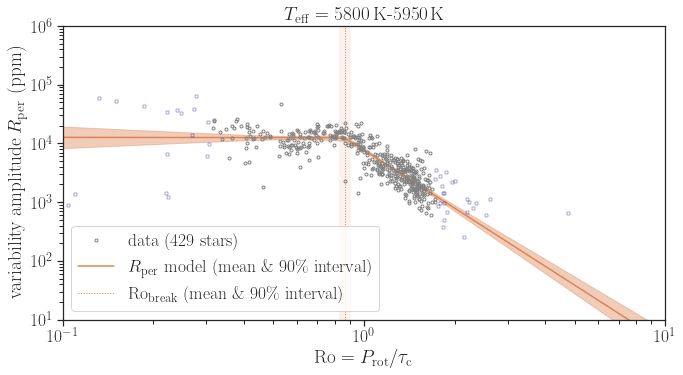

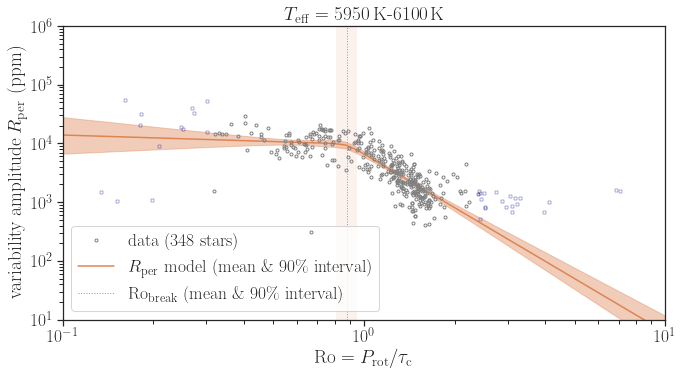

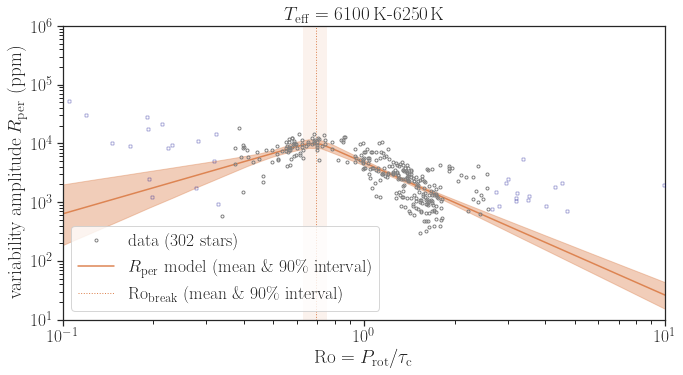

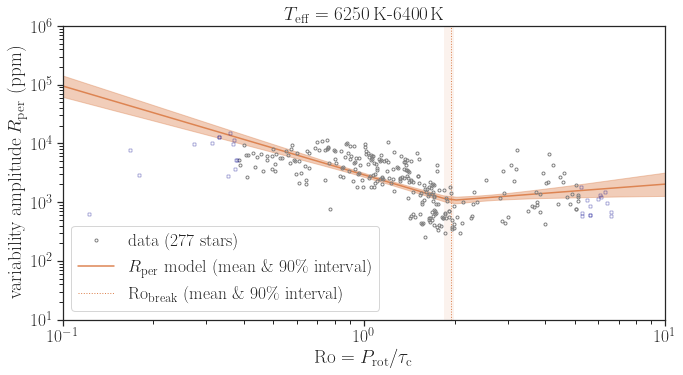

In [37]:
for i in range(len(tbins)-1):
    tl, tu = tbins[i], tbins[i+1]
    outname = resdir+"teff%d-%d"%(tl, tu)
    print (outname)    

    idx = (d.teff>tl) & (d.teff<tu) #& (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Pnorm, [5, 95])
    print (pmin, pmax)
    
    idxp = (pmin<d.Pnorm) & (d.Pnorm<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Pnorm), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Pnorm, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))   
        mcmc.print_summary()
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 1000, 5000//5
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax, #xb_lower=0.5, xb_upper=2., 
                 xb_lower=np.fmax(pmin, 0.5), xb_upper=np.fmin(pmax, 2.), 
                 xd_lower=0.1, xd_upper=10, extra_fields=('potential_energy',))
        mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.exp(jnp.mean(samples['logrmodeldense'], axis=0))
    r5, r95 = jnp.exp(jnp.percentile(samples['logrmodeldense'], q=jnp.array([5, 95]), axis=0))
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12*0.9,6*0.9))
    plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(0.1, 10)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(pnlabel)
    #idxd = (pobs>pmin) & (pobs<pmax)
    if tu-tl>1000:
        mew=0.5
        plt.plot(pobs, robs, '.', color='gray', markersize=1, zorder=1000, alpha=0.8, label='data (%d stars)'%len(pobs))
        #plt.plot(pobs_out, robs_out, '.', color='gray', markersize=1, zorder=1000, alpha=0.4)
        plt.plot(pobs_out, robs_out, 's', color='darkblue', zorder=1000, alpha=0.8, markersize=3, mfc='none', mew=0.4)
    else:
        mew=1.
        plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=mew, zorder=1000, label='data (%d stars)'%len(pobs))
        #plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=mew, zorder=1000, alpha=0.7)
        plt.plot(pobs_out, robs_out, 's', color='darkblue', zorder=1000, alpha=0.8, markersize=3, mfc='none', mew=0.4)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$\mathrm{Ro}_\mathrm{break}$ (mean \& 90\% interval)')
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1)
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_romodel.png", dpi=200, bbox_inches="tight")

In [38]:
resdir = 'plfitro_results_t%d_pct/'%dt

In [89]:
tbins_all = np.array([4000, 6250])
resume = True
magcut = True * 0

In [90]:
resdir

'plfitro_results_t150_pct/'

plfitro_results_t150_pct/teff4000-6250
0.3278715297594667 1.6643812046887563

                    mean       std    median      5.0%     95.0%     n_eff     r_hat
       R_break  10804.99    283.03  10790.04  10378.31  11294.44    368.30      1.00
     lnp_break     -0.18      0.01     -0.17     -0.20     -0.15    385.08      1.00
   lnxmodel[0]      0.25      0.00      0.25      0.25      0.26   8739.71      1.00
   lnxmodel[1]      0.39      0.00      0.39      0.39      0.40   9621.50      1.00
   lnxmodel[2]      0.27      0.00      0.27      0.26      0.27   7762.87      1.00
   lnxmodel[3]     -0.01      0.00     -0.01     -0.01     -0.01   8243.07      1.00
   lnxmodel[4]      0.31      0.00      0.31      0.31      0.32   7983.23      1.00
   lnxmodel[5]     -0.62      0.00     -0.62     -0.62     -0.61  10821.00      1.00
   lnxmodel[6]     -0.12      0.00     -0.12     -0.12     -0.12   8289.70      1.00
   lnxmodel[7]     -0.59      0.00     -0.59     -0.59     -0.58  10137.

lnxmodel[1704]      0.40      0.00      0.40      0.39      0.40   8434.64      1.00
lnxmodel[1705]      0.14      0.00      0.14      0.13      0.14   9718.54      1.00
lnxmodel[1706]     -0.02      0.00     -0.02     -0.02     -0.02   7737.04      1.00
lnxmodel[1707]      0.04      0.00      0.04      0.03      0.04  12589.22      1.00
lnxmodel[1708]     -0.05      0.00     -0.05     -0.05     -0.04   7159.96      1.00
lnxmodel[1709]      0.39      0.00      0.39      0.39      0.40   9007.05      1.00
lnxmodel[1710]      0.04      0.00      0.04      0.04      0.04   9706.21      1.00
lnxmodel[1711]      0.03      0.00      0.03      0.02      0.03   9015.43      1.00
lnxmodel[1712]      0.05      0.00      0.05      0.05      0.05   9322.82      1.00
lnxmodel[1713]     -0.37      0.00     -0.37     -0.37     -0.36   8931.74      1.00
lnxmodel[1714]     -1.07      0.00     -1.07     -1.07     -1.07   9940.93      1.00
lnxmodel[1715]     -0.01      0.00     -0.01     -0.01     -0.00 

lnxmodel[2892]     -0.38      0.00     -0.38     -0.38     -0.37   7738.39      1.00
lnxmodel[2893]      0.12      0.00      0.12      0.11      0.12  11274.34      1.00
lnxmodel[2894]      0.12      0.00      0.12      0.12      0.13   8377.44      1.00
lnxmodel[2895]      0.28      0.00      0.28      0.27      0.28   9764.14      1.00
lnxmodel[2896]      0.37      0.00      0.37      0.37      0.37  10107.07      1.00
lnxmodel[2897]     -0.13      0.00     -0.13     -0.14     -0.13   8091.13      1.00
lnxmodel[2898]      0.36      0.00      0.36      0.35      0.36  10849.39      1.00
lnxmodel[2899]      0.04      0.00      0.04      0.04      0.04   8998.06      1.00
lnxmodel[2900]     -1.11      0.00     -1.11     -1.12     -1.11    229.53      1.00
lnxmodel[2901]      0.21      0.00      0.21      0.20      0.21   9774.78      1.00
lnxmodel[2902]      0.03      0.00      0.03      0.03      0.04  10175.16      1.00
lnxmodel[2903]      0.14      0.00      0.14      0.14      0.14 

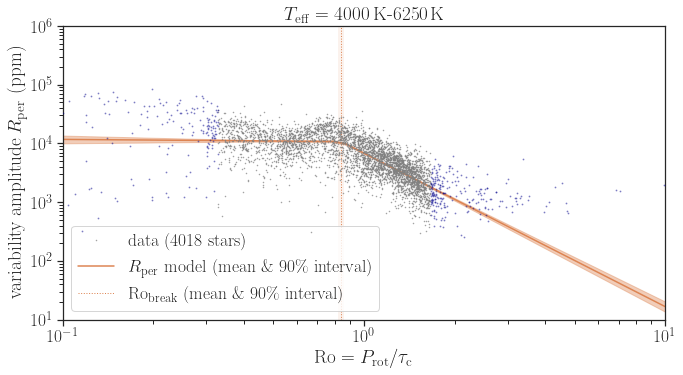

In [91]:
for i in range(len(tbins_all)-1):
    tl, tu = tbins_all[i], tbins_all[i+1]
    outname = resdir+"teff%d-%d"%(tl, tu)
    print (outname)    

    idx = (d.teff>tl) & (d.teff<tu) #& (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Pnorm, [5, 95])
    print (pmin, pmax)
    
    if magcut:
        idx &= (d.kepmag < 12)
        outname += "_kp12"
    
    idxp = (pmin<d.Pnorm) & (d.Pnorm<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Pnorm), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Pnorm, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))   
        mcmc.print_summary()
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 1000, 5000
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax, #xb_lower=0.5, xb_upper=2., 
                 xb_lower=np.fmax(pmin, 0.5), xb_upper=np.fmin(pmax, 2.), 
                 xd_lower=0.1, xd_upper=10, extra_fields=('potential_energy',))
        mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.exp(jnp.mean(samples['logrmodeldense'], axis=0))
    r5, r95 = jnp.exp(jnp.percentile(samples['logrmodeldense'], q=jnp.array([5, 95]), axis=0))
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12*0.9,6*0.9))
    if 'kp12' in outname:
        plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$ ($K_p<12$)"%(tl, tu))
    else:
        plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(0.1, 10)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(pnlabel)
    #idxd = (pobs>pmin) & (pobs<pmax)
    if tu-tl>1000 and len(pobs)>300:
        mew=0.5
        plt.plot(pobs, robs, '.', color='gray', markersize=1, zorder=1000, alpha=0.8, label='data (%d stars)'%len(pobs))
        #plt.plot(pobs_out, robs_out, '.', color='gray', markersize=1, zorder=1000, alpha=0.4)
        plt.plot(pobs_out, robs_out, 's', color='darkblue', zorder=1000, alpha=0.8, markersize=1, mfc='none', mew=0.4)
    else:
        mew=1.
        plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=mew, zorder=1000, label='data (%d stars)'%len(pobs))
        #plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=mew, zorder=1000, alpha=0.7)
        plt.plot(pobs_out, robs_out, 's', color='darkblue', zorder=1000, alpha=0.8, markersize=3, mfc='none', mew=0.4)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$\mathrm{Ro}_\mathrm{break}$ (mean \& 90\% interval)')
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1)
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_romodel.png", dpi=200, bbox_inches="tight")
    
    continue
    
    keys = ["R_break", "p_break", "power_long", "power_short", "logrsigma", "lnxsigma"]
    labels = ['Rb', 'Pb', 'pl', 'ps', 'logrsigma', 'logxsigma']
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
    fig = corner.corner(hyper, labels=labels, show_titles="%.2f")
    plt.savefig(outname+"_corner.png", dpi=200, bbox_inches="tight")

## residual

In [92]:
res = np.array(np.log10(robs) - jnp.mean(np.log10(samples['rmodel']), axis=0))

In [93]:
rnds = np.random.randn(int(1e7))*np.mean(samples['logrsigma'])*np.log10(np.e)

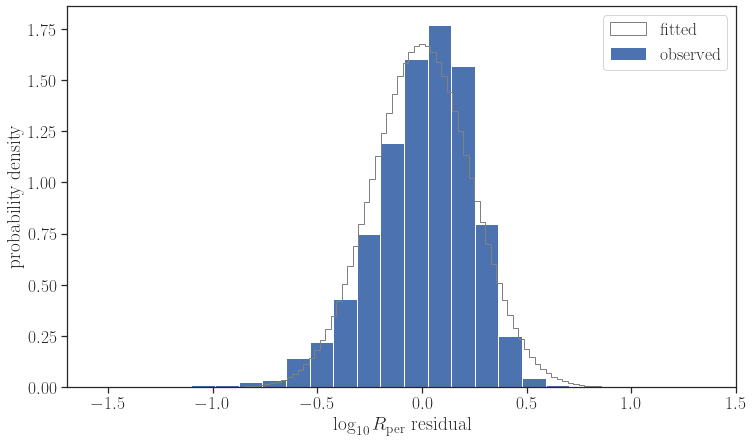

In [94]:
plt.figure(figsize=(12,7))
plt.xlabel("$\log_{10} R_\mathrm{per}$ residual")
plt.ylabel("probability density")
plt.hist(rnds, bins=100, density=True, histtype='step', lw=1, color='gray', label='fitted')
plt.hist(res, bins=20, density=True, label='observed')
plt.legend(loc='best')

### FeH dependence

In [106]:
fehobs = d[idx&idxp].feh
teffobs = d[idx&idxp].teff
meansigma = np.mean(samples['logrsigma'])*np.log10(np.e)

In [96]:
from scipy.stats import pearsonr

In [98]:
idxf = np.abs(fehobs)<0.5
print ("Pearson R:", pearsonr(fehobs[idxf], res[idxf]))
a, b = np.polyfit(fehobs[idxf], res[idxf], deg=1)
print (a, b)

Pearson R: (0.3733569296937605, 6.14425011133872e-132)
0.5262794360056346 -0.015036732702251351


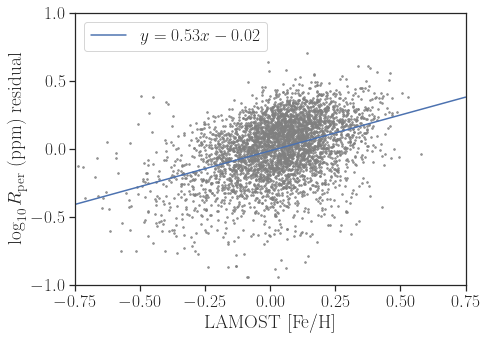

In [105]:
plt.figure(figsize=(7,5))
plt.ylim(-1, 1)
plt.xlim(-0.75, 0.75)
plt.xlabel("LAMOST [Fe/H]")
plt.ylabel("$\log_{10}R_\mathrm{per}$ (ppm) residual")
plt.plot(fehobs, res, '.', markersize=3, color='gray', mfc='none')
feh0 = np.linspace(-0.75, 0.75, 100)
plt.plot(feh0, a*feh0+b, label='$y=%.2fx-%.2f$'%(a, -b))
plt.legend(loc='upper left')
plt.savefig(resdir+"feh.png", dpi=200, bbox_inches='tight')

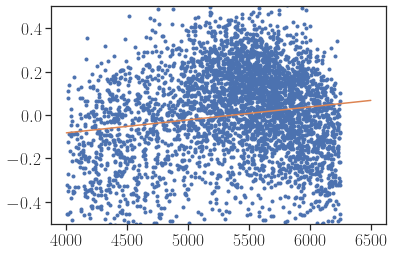

In [120]:
plt.plot(teffobs, res, '.')
t0 = np.linspace(4000, 6500, 100)
plt.ylim(-0.5, 0.5)
plt.plot(t0, np.poly1d(np.polyfit(teffobs, res, deg=1))(t0))
#plt.plot(teffobs, res-(0.53*fehobs-0.02), '.')

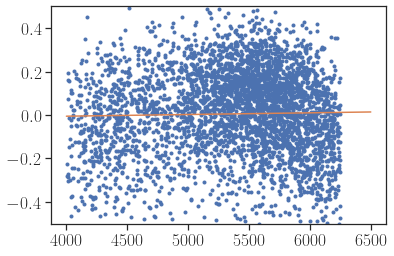

In [121]:
resf = res-(0.53*fehobs-0.02)
plt.ylim(-0.5, 0.5)
plt.plot(teffobs, resf, '.')
t0 = np.linspace(4000, 6500, 100)
plt.plot(t0, np.poly1d(np.polyfit(teffobs, resf, deg=1))(t0))
#plt.plot(teffobs, res-(0.53*fehobs-0.02), '.')